In [20]:
# --- Notebook setup ---
from pathlib import Path
from IPython.display import display
import sys
import yaml
import logging
import numpy as np
import pandas as pd

# --- Path setup ---
# Notebook is in: <repo_root>/notebooks
# We go one directory up to reach repo root
PROJECT_ROOT = Path.cwd().parents[0]
SRC_PATH = PROJECT_ROOT / "src"

# Add the repo root (not just src) to the Python path
# so we can import using: from src.data.data import Data
sys.path.append(str(PROJECT_ROOT))

print("✅ Project root:", PROJECT_ROOT)
print("✅ SRC path added:", SRC_PATH)

# --- Logging setup ---
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# --- Import your Data class ---
from src.data.data import Data  

✅ Project root: /Users/anderas/Documents/PhD/Projects/1. TabPFN/TabPFNCredit
✅ SRC path added: /Users/anderas/Documents/PhD/Projects/1. TabPFN/TabPFNCredit/src


INFO: Loading PD dataset: 01_gmsc


✅ YAML configs loaded successfully
Task: pd
Selected dataset(s): ['01_gmsc']
✅ Data class initialized
Resolved PROJECT_ROOT: n/a
Resolved DATA_ROOT: n/a


INFO: 01_gmsc loaded
INFO: Subsampling DataFrame from 150000 to 1000 rows.
INFO: 01_gmsc preprocessed
INFO: x shape: (1000, 10)
INFO: y shape: (1000,)


✅ Data loaded and preprocessed: x=(1000, 10), y=(1000,)
🧾 Preview of preprocessed data (first 5 rows):


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.029690,57.0,0.0,0.283244,10121.0,7.0,0.0,1.0,0.0,0.0
1,0.000000,57.0,0.0,0.142562,7750.0,9.0,0.0,1.0,0.0,0.0
2,0.036569,48.0,0.0,0.236294,6000.0,6.0,0.0,2.0,0.0,3.0
3,1.018331,41.0,0.0,0.163138,4958.0,4.0,0.0,0.0,0.0,0.0
4,1.008799,49.0,0.0,3942.000000,NaN,10.0,0.0,1.0,0.0,0.0


✅ Generated 3 cross-validation folds
Fold 0 split sizes: {'train': 532, 'val': 134, 'test': 334}
✅ TALENT dataset dicts created
Info: {'task_type': 'classification'}
Train: (532, 10) Val: (134, 10) Test: (334, 10)

📊 Metadata summary:
  dataset_name: 01_gmsc
  n_samples: 1000
  n_features: 10
  n_categorical: 0
  n_numeric: 10

✅ All consistency checks passed!


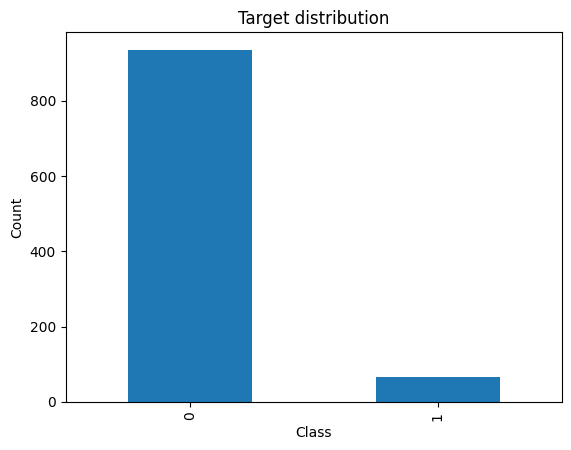

In [21]:
# --- Block: Full data.py functionality test ---

from IPython.display import display
from pathlib import Path
import yaml, numpy as np, pandas as pd

# 1) Load YAML configs
config_path = PROJECT_ROOT / "config"
with open(config_path / "CONFIG_DATA.yaml", "r") as f:
    dataconfig = yaml.safe_load(f)
with open(config_path / "CONFIG_EXPERIMENT.yaml", "r") as f:
    experimentconfig = yaml.safe_load(f)

task = experimentconfig["task"].strip().lower()
print("✅ YAML configs loaded successfully")
print("Task:", task)
print("Selected dataset(s):", [k for k, v in dataconfig[f"dataset_{task}"].items() if v])

# 2) Initialize Data class
data = Data(dataconfig, experimentconfig)
print("✅ Data class initialized")
print("Resolved PROJECT_ROOT:", getattr(data, "PROJECT_ROOT", "n/a"))
print("Resolved DATA_ROOT:", getattr(data, "DATA_ROOT", "n/a"))

# 3) Load and preprocess data
x, y = data.load_preprocess_data()
print(f"✅ Data loaded and preprocessed: x={x.shape}, y={y.shape}")

# Always display first few rows
preview_cols = data.cols[:x.shape[1]] if getattr(data, "cols", None) else [f"f{i}" for i in range(x.shape[1])]
preview_df = pd.DataFrame(x[:5, :], columns=preview_cols)
print("🧾 Preview of preprocessed data (first 5 rows):")
display(preview_df)

# 4) Generate CV splits
split_indices = data.split_data()
print(f"✅ Generated {len(split_indices)} cross-validation folds")
fold = 0
print(f"Fold {fold} split sizes:", {k: len(v) for k, v in split_indices[fold].items()})

# 5) Create TALENT-ready datasets
train_val_data, test_data, info = data.get_talent_datasets(split_indices, fold)
print("✅ TALENT dataset dicts created")
print("Info:", info)
print("Train:", train_val_data["x"].shape, "Val:", train_val_data["val_x"].shape, "Test:", test_data["x"].shape)

# 6) Metadata & validations
meta = data.metadata
print("\n📊 Metadata summary:")
for k, v in meta.items():
    print(f"  {k}: {v}")

# Sanity checks
assert isinstance(x, np.ndarray), "x is not numpy array"
assert isinstance(y, np.ndarray), "y is not numpy array"
assert x.shape[0] == y.shape[0], "Mismatch in number of samples"
assert x.shape[1] > 0, "No features detected"
cat = set(getattr(data, "cols_cat", []))
num = set(getattr(data, "cols_num", []))
all_cols = set(getattr(data, "cols", preview_cols))
assert cat.isdisjoint(num), "A column is marked both categorical and numerical"
assert cat | num == all_cols, "Categorical+numerical do not cover all columns"

print("\n✅ All consistency checks passed!")

# Optional: quick target distribution (only for classification)
if info.get("task_type") == "classification":
    ax = pd.Series(data.y).value_counts().sort_index().plot(kind='bar', title='Target distribution')
    ax.set_xlabel('Class'); ax.set_ylabel('Count')


In [24]:
# --- Notebook: Test generic_preprocessing.py ---

import numpy as np
import pandas as pd
import warnings
import logging
from pathlib import Path

# --- Setup logger ---
logger = logging.getLogger()
if not logger.handlers:
    logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# --- Import functions from your module ---
from src.data.generic_preprocessing import (
    handle_missing_values,
    encode_cat_vars,
    standardize_data,
    _introduce_class_imbalance
)

# --- 1️⃣ Create a small synthetic dataset ---
np.random.seed(42)
n = 20

# Numeric and categorical parts
x_num = np.random.randn(n, 2) * 10                   # numeric columns
x_cat = np.random.choice(["A", "B", "C"], size=(n, 1))  # categorical column

# ✅ Force correct dtypes (to prevent numpy from upcasting all to <U32)
x = np.empty((n, 3), dtype=object)
x[:, :2] = x_num
x[:, 2] = x_cat.flatten()

# Binary target
y = np.random.choice([0, 1], size=n)

# Introduce missing values
x[3, 0] = np.nan
x[5, 1] = np.nan
x[7, 2] = np.nan

# Train / val / test splits
x_train, x_val, x_test = x[:12], x[12:16], x[16:]
y_train, y_val, y_test = y[:12], y[12:16], y[16:]

# Column metadata
cols = ["feature1", "feature2", "category"]
cols_num_idx = [0, 1]
cols_cat_idx = [2]
cols_cat = ["category"]

# --- 2️⃣ Define dummy CONFIG_METHOD.yaml equivalent ---
methodconfig = {
    "missing_values": 2,  # 0=none, 1=drop, 2=impute(mean/mode), 3=impute(median/mode)
    "encode_cat": 1,      # 0=none, 1=one-hot, 2=WoE
    "standardize": 1      # 0=none, 1=StandardScaler, 2=MinMaxScaler
}

print("✅ Synthetic data prepared")
print("x_train shape:", x_train.shape)
print("Missing values in x_train:", pd.isna(x_train[:, :2]).sum())

# --- 3️⃣ Test missing value handling ---
x_train_filled, x_val_filled, x_test_filled, y_train_filled, y_val_filled, y_test_filled = handle_missing_values(
    x_train.copy(), x_val.copy(), x_test.copy(),
    y_train.copy(), y_val.copy(), y_test.copy(),
    methodconfig, cols_num_idx, cols_cat_idx
)

print("\n✅ handle_missing_values executed")
print("Remaining NaNs in x_train:", pd.DataFrame(x_train_filled).isna().sum().sum())

# --- 4️⃣ Test categorical encoding ---
x_train_enc, x_val_enc, x_test_enc, y_train_enc, y_val_enc, y_test_enc = encode_cat_vars(
    x_train_filled.copy(), x_val_filled.copy(), x_test_filled.copy(),
    y_train_filled.copy(), y_val_filled.copy(), y_test_filled.copy(),
    methodconfig, cols_cat, cols_cat_idx
)

print("\n✅ encode_cat_vars executed")
print("Encoded shapes:")
print("  Train:", x_train_enc.shape, "Val:", x_val_enc.shape, "Test:", x_test_enc.shape)

# --- 5️⃣ Test standardization ---
x_train_std, x_val_std, x_test_std, y_train_std, y_val_std, y_test_std = standardize_data(
    x_train_enc.copy(), x_val_enc.copy(), x_test_enc.copy(),
    y_train_enc.copy(), y_val_enc.copy(), y_test_enc.copy(),
    methodconfig
)

print("\n✅ standardize_data executed")
print("Mean of standardized training data (approx 0):", np.round(np.mean(x_train_std, axis=0), 3))
print("Std of standardized training data (approx 1):", np.round(np.std(x_train_std, axis=0), 3))

# --- 6️⃣ Test artificial class imbalance creation ---
x_bal, y_bal = _introduce_class_imbalance(
    x_train_std.copy(), y_train_std.copy(), imbalance_ratio=0.2, random_state=42
)

print("\n✅ _introduce_class_imbalance executed")
print("Original class distribution:", dict(zip(*np.unique(y_train_std, return_counts=True))))
print("Balanced class distribution:", dict(zip(*np.unique(y_bal, return_counts=True))))

# --- 7️⃣ Display sample output ---
print("\n🧾 First few rows of final standardized + encoded data:")
pd.set_option("display.max_columns", None)
display(pd.DataFrame(x_train_std[:5, :]))


INFO: Imputed missing values with (num: mean) and (cat: mode)
INFO: Class distribution BEFORE imbalance: {0: 9, 1: 3}
INFO: Current minority ratio: 0.33, Desired: 0.2
INFO: Class distribution AFTER imbalance: {0: 9, 1: 1}
INFO: Total samples: 10



✅ Synthetic data prepared
x_train shape: (12, 3)
Missing values in x_train: 2

✅ handle_missing_values executed
Remaining NaNs in x_train: 0

✅ encode_cat_vars executed
Encoded shapes:
  Train: (12, 5) Val: (4, 5) Test: (4, 5)

✅ standardize_data executed
Mean of standardized training data (approx 0): [-0.  0. -0.  0. -0.]
Std of standardized training data (approx 1): [1. 1. 1. 1. 1.]

✅ _introduce_class_imbalance executed
Original class distribution: {0: 9, 1: 3}
Balanced class distribution: {0: 9, 1: 1}

🧾 First few rows of final standardized + encoded data:


,0,1,2,3,4
0,8.260279e-01,0.119443,-0.301511,-1.414214,1.732051
1,1.012486e+00,1.876005,-0.301511,0.707107,-0.577350
2,-7.661820e-02,0.018073,-0.301511,0.707107,-0.577350
3,2.742326e-17,1.077080,-0.301511,0.707107,-0.577350
4,-3.672476e-01,0.839310,-0.301511,0.707107,-0.577350
